# **Black-Scholes option pricing**

El propósito de este análisis es explorar diferentes métodos para la valoración de opciones dentro del marco del modelo de precios de Black-Scholes utilizando Python. En particular, nos basaremos en métodos de Monte Carlo para la valoración de opciones de compra europeas y compararemos los resultados con los obtenidos a través de la solución exacta de Black-Scholes.

La solución de la ecuación de Black-Scholes para una opción de compra europea C(S,t)
C(S,t), dado un vencimiento T y el precio de ejercicio X, está dada por:

![Descripción de la imagen](../Project-image/BS1.png)

donde,

![Descripción de la imagen](../Project-image/BS2.png)

y donde N(d) is la distribución normal acumulativa:

![Descripción de la imagen](../Project-image/BS3.png)

# **Solución Exacta**

Primero nos centramos en la solución exacta para el precio de una opción de compra C(S,t)

In [40]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt 
from math import log, sqrt, exp
import seaborn as sns
import numpy.random as npr



Definimos la solución exacta directamente:

In [124]:
def BS_Call_Exact(S, X, r, sigma, T, t):
    d1 = (log(S/X)+(r+((sigma**2)/2))*(T-t))/(sigma*sqrt((T-t)))
    d2 = d1-sigma*sqrt((T-t))
    
    ST = S*stats.norm.cdf(d1) - X*exp(-r*(T-t))*stats.norm.cdf(d2)
    
    return ST

Graficamos algunas de la soluciones de C en función de t. Cogemos S = 100 y usamos X = 95,98,100,105. En el resto de este análisis, siempre estableceremos las siguientes condiciones y parámetros para nuestras simulaciones y cálculos T = 1, r = 0,06, v = 0,3

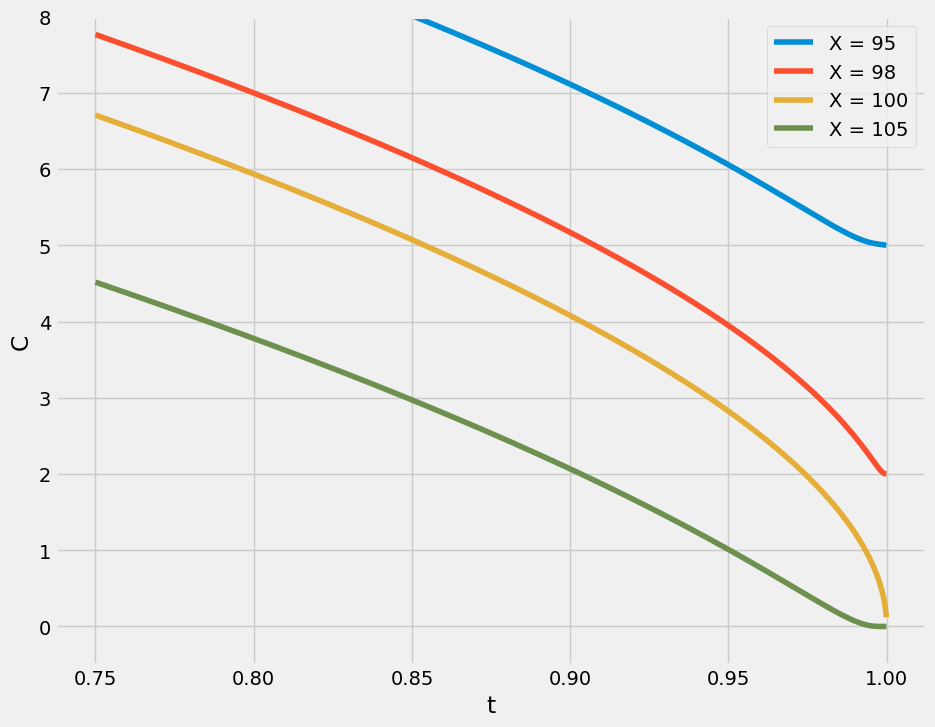

In [125]:
S = 100
T = 1
r = 0.06
sigma = 0.3

# Precios de ejercicio (X)
X_values = [95, 98, 100, 105]

# Valores para t
t = np.arange(0.75, 1.0, 0.0001)

plt.figure(figsize=(10, 8))

for X in X_values:
    prices = [BS_Call_Exact(S, X, r, sigma, T, time) for time in t]
    plt.plot(t, prices, label=f'X = {X}')

plt.xlabel('t')
plt.ylabel('C')
plt.ylim(-0.5, 8)

plt.legend()
plt.show()

En particular, para T - t = 0, tenemos la función estándar para la opción de compra al vencimiento:

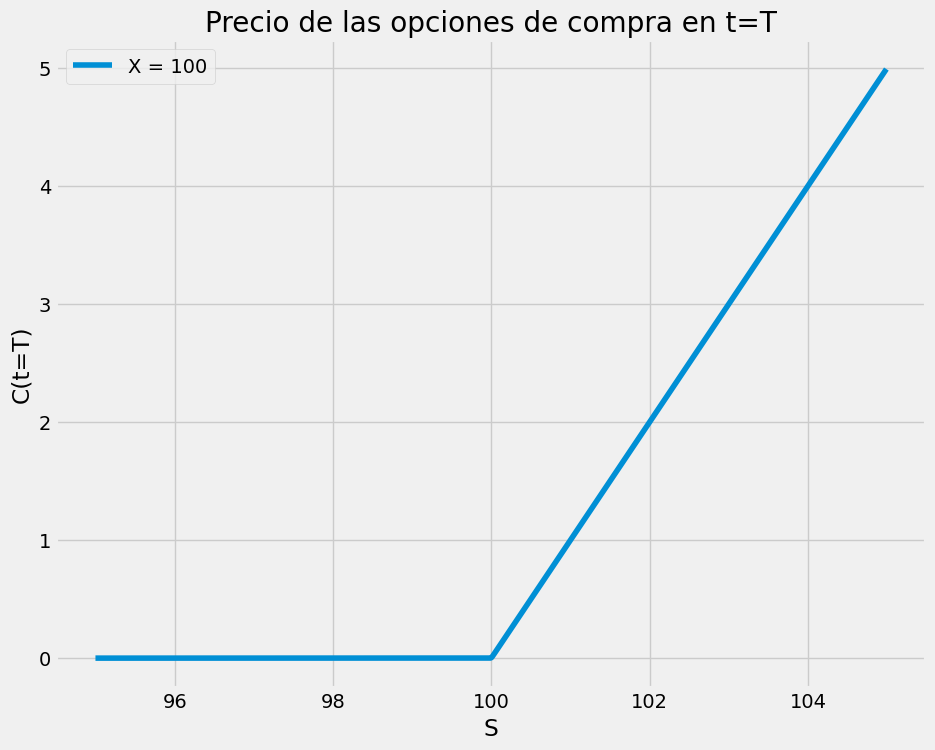

In [54]:
T = 1
r = 0.06
sigma = 0.3
t = 0.9999999

# Valores para S
s = np.arange(95, 105, 0.01)

# Calcular el precio de la opción de compra para cada valor de S en el array s
prices = [BS_Call_Exact(S, 100, r, sigma, T, t) for S in s]

plt.figure(figsize=(10, 8))

sns.lineplot(x=s, y=prices, label='X = 100')

plt.xlabel('S')
plt.ylabel('C(t=T)')
plt.title('Precio de las opciones de compra en t=T')

plt.legend()
plt.show()

# **Monte Carlo**

Otra alternativa para calcular el precio de una opción de compra es usar el método de Monte Carlo. El punto de partida es tomar la ecuación del movimiento Browniano para el activo subyacente S(t): 

![Descripción de la imagen](../Project-image/BS4.png)

Esta ecuación puede ser discretizada por medio de un esquema de Euler. Al hacer esto, obtenemos el nivel del índice de acciones S(T) en el vencimiento T dado un nivel S(t) como:

![Descripción de la imagen](../Project-image/BS5.png)

Podemos simular el proceso de S(T) usando el método de Monte Carlo. Como ejemplo: r = 0,06, v = 0,3, T-t = 1, S = 100. Realizamos 100.000 iteraciones y cogemos M = 100 intervalos para la discretización del intervalo de tiempo. 

In [57]:
r = 0.06
sigma = 0.3
T = 1
S0 = 100
I = 100000
M = 100

dt = T / M

S = np.zeros((M + 1, I))
S[0] = S0

for step in range(1, M + 1):
    S[step] = S[step - 1] * np.exp((r - 0.5 * sigma ** 2) * dt +
                                    sigma * np.sqrt(dt) * np.random.standard_normal(I))

Observamos que S(i) tiene una distribución log-normal:

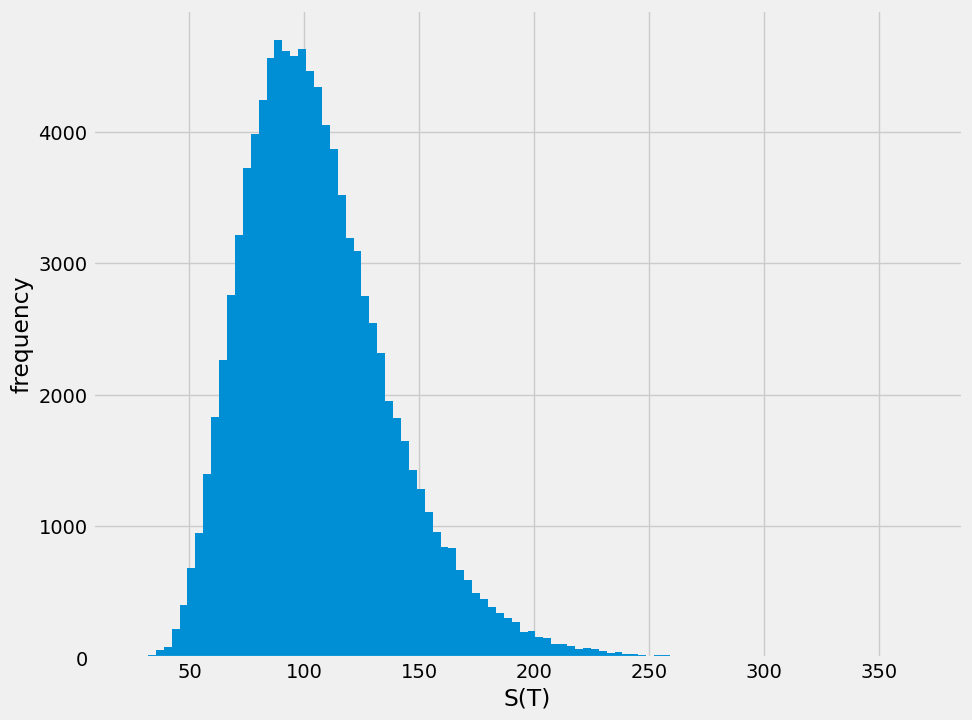

In [58]:
plt.figure(figsize=(10, 8))
plt.hist(S[-1], bins=100)
plt.xlabel('S(T)')
plt.ylabel('frequency')
plt.show()

También observamos que S(t) sigue un movimiento browniano geométrico:

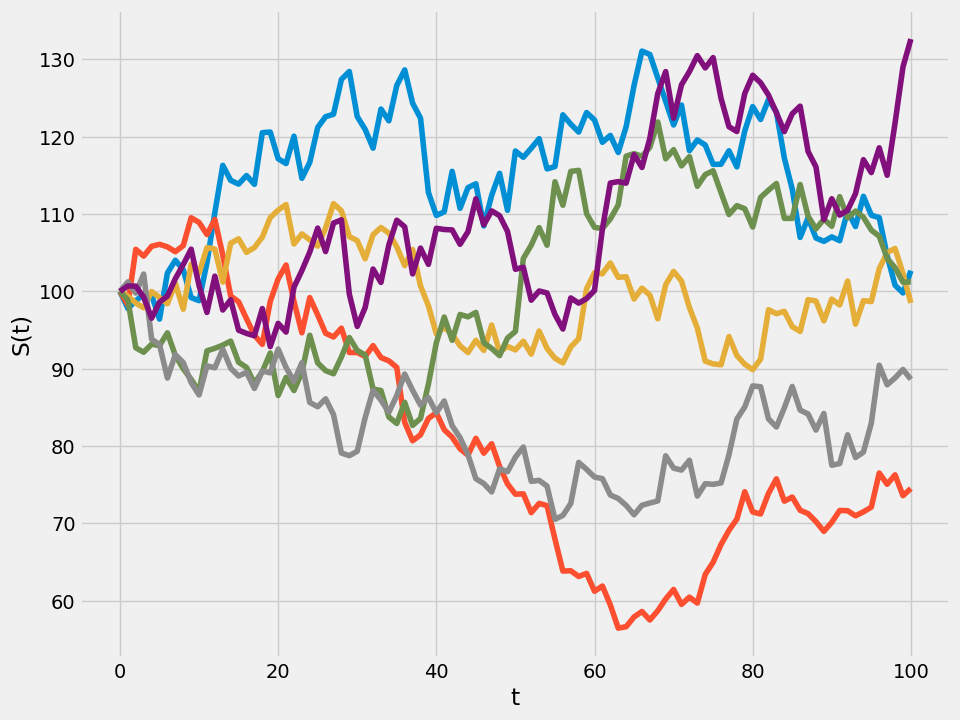

In [59]:
plt.figure(figsize=(10, 8))
plt.plot(S[:, :6])
plt.xlabel('t')
plt.ylabel('S(t)')
plt.show()

Sabemos que, en el caso de las opciones de compra, el función del payoff al vencimiento T es dado por:


Entonces, en el caso particular de un entorno libre de riesgos, se puede demostrar que el precio de la opción de compra está dado por:

![Descripción de la imagen](../Project-image/BS6.png)

donde q(S) es una densidad de probabilidad para el proceso martingala equivalente a S(t). Esta integral puede ser discretizada, dando como resultado:

![Descripción de la imagen](../Project-image/BS7.png)

donde la suma se toma sobre una colección S(Ti) que sigue un movimiento browniano geométrico que puede ser generado por simulacón de Monte Carlo. 

![Descripción de la imagen](../Project-image/BS8.png)



In [101]:
def BS_Call_MC(S, X, r, sigma, T, t, I):
    # Crear una matriz para almacenar los resultados de cada iteración
    data = np.zeros((I, 2))
    
    # Generar números aleatorios a partir de una distribución normal estándar
    z = np.random.normal(0, 1, I)
    
    # Calcular el precio futuro del activo subyacente usando el modelo de Black-Scholes
    ST = S * np.exp((T - t) * (r - 0.5 * sigma ** 2) + sigma * np.sqrt(T - t) * z)
    
    # Calcular el payoff de la opción de compra para cada iteración
    data[:, 1] = np.maximum(ST - X, 0)
    
    # Calcular el promedio del payoff y ajustarlo al precio presente
    average = np.sum(data[:, 1]) / float(I)
    option_price = np.exp(-r * (T - t)) * average
    
    return option_price

In [119]:
# Definir los parámetros
S = 100
X = 95
r = 0.06
sigma = 0.3
T = 1
t = 0.999
I = 100000

# Calcular el precio de la opción de compra usando el método de Monte Carlo
option_price_mc = BS_Call_MC(S, X, r, sigma, T, t, I)

# Calcular el precio de la opción de compra exacto
option_price_exact = BS_Call_Exact(S, X, r, sigma, T, t)

print('Monte Carlo:', option_price_mc)
print('Exacto:', option_price_exact)

Monte Carlo: 5.003531488089681
Exacto: 5.005699833982007


Podemos graficar cómo el valor de la opción de compra de Monte Carlo converge al valor exacto a medida que aumenta el número de iteraciones:

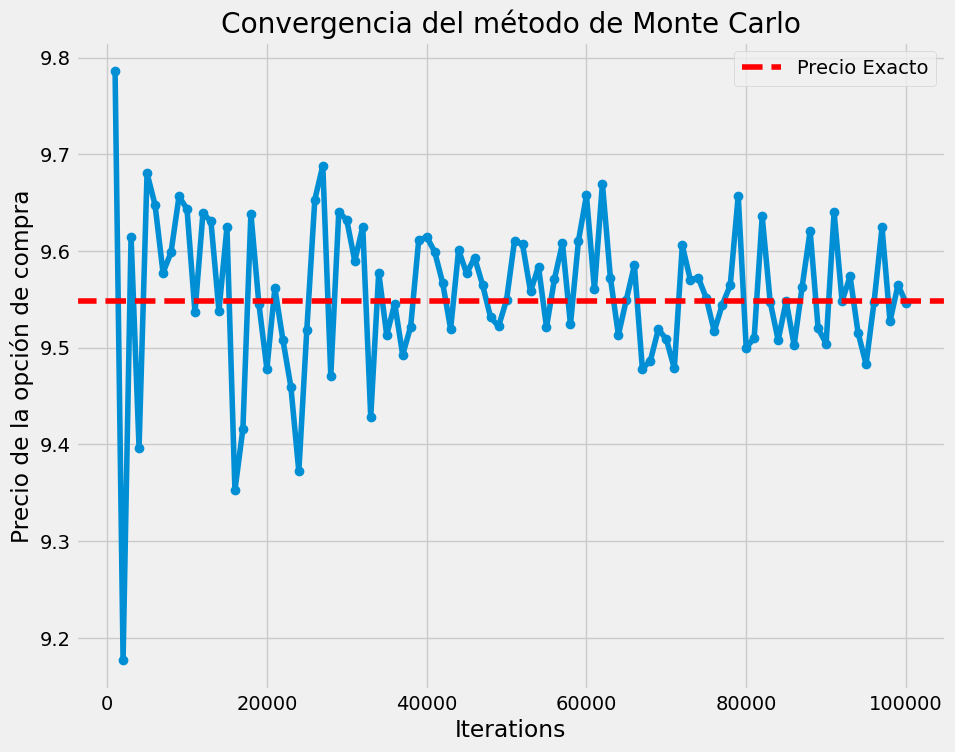

In [123]:
# Graficar el convergencia del método de Monte Carlo
iterations = np.arange(1000, I+1000, 1000)
option_prices = [BS_Call_MC(S, X, r, sigma, T, t, it) for it in iterations]

plt.figure(figsize=(10, 8))

plt.plot(iterations, option_prices, marker='o', linestyle='-')
plt.axhline(y=option_price_exact, color='r', linestyle='--', label='Precio Exacto')
plt.xlabel('Iterations')
plt.ylabel('Precio de la opción de compra')
plt.title('Convergencia del método de Monte Carlo')
plt.legend()
plt.grid(True)
plt.show()

In [121]:
S = 100
X = 95
r = 0.06
sigma = 0.3
T = 1
t = 0.75
I = 100000

# Calcular el precio de la opción de compra usando el método de Monte Carlo
option_price_mc = BS_Call_MC(S, X, r, sigma, T, t, I)

# Calcular el precio de la opción de compra exacto
option_price_exact = BS_Call_Exact(S, X, r, sigma, T, t)

print('Monte Carlo:', option_price_mc)
print('Exacto:', option_price_exact)

Monte Carlo: 9.564742503417573
Exacto: 9.548802012535894


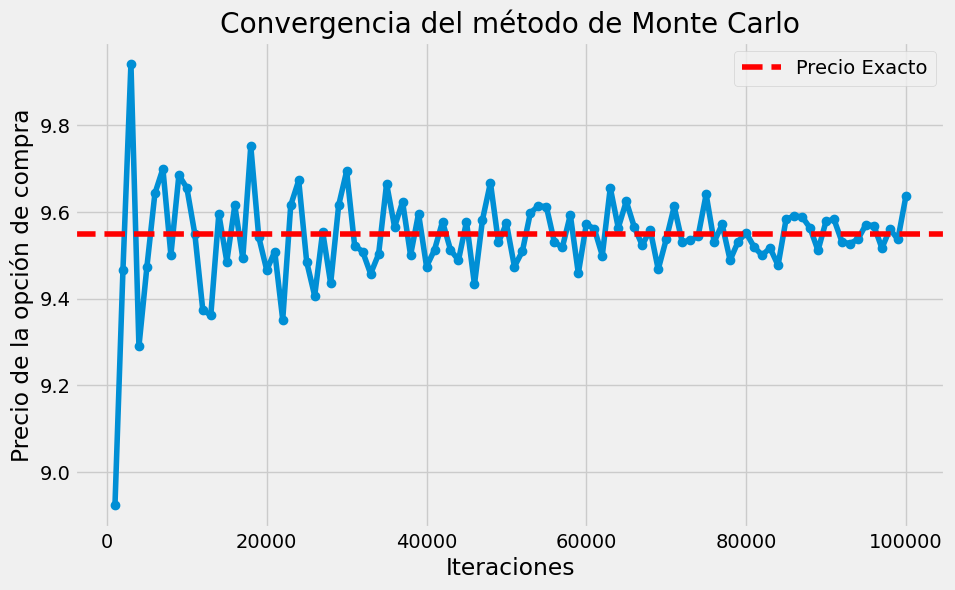

In [122]:
# Graficar el convergencia del método de Monte Carlo
iterations = np.arange(1000, I+1000, 1000)
option_prices = [BS_Call_MC(S, X, r, sigma, T, t, it) for it in iterations]

plt.figure(figsize=(10, 6))
plt.plot(iterations, option_prices, marker='o', linestyle='-')
plt.axhline(y=option_price_exact, color='r', linestyle='--', label='Precio Exacto')
plt.xlabel('Iteraciones')
plt.ylabel('Precio de la opción de compra')
plt.title('Convergencia del método de Monte Carlo')
plt.legend()
plt.grid(True)
plt.show()